# Imaging and image modeling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
%matplotlib inline
import cv2

In [2]:
plt.rcParams["figure.facecolor"]=(1,1,1,1)

In this notebook, we explore a few imaging related models and camera image processing operations.

## Pinhole camera model

First, we demonstrate, how 3D points are projected to a 2D image using the pinhole camera model. The points are randomly generated.

In [3]:
n=5
X = np.random.rand(n)*10-5
Y = np.random.rand(n)*10-5
Z = np.random.rand(n)*10+30

Then they are projected to the image plane that is at the distance $f$ from the pinhole.

In [4]:
f=5

In [5]:
x=f*X/Z
y=f*Y/Z

In [6]:
implane=np.array([[-1,-1,-f],
                  [-1,1,-f],
                  [1,1,-f],
                  [1,-1,-f],
                  [-1,-1,-f]])

The following figure shows how the rays coming from the 3D points intersect at the same point (pinhole) before hitting the image plane.

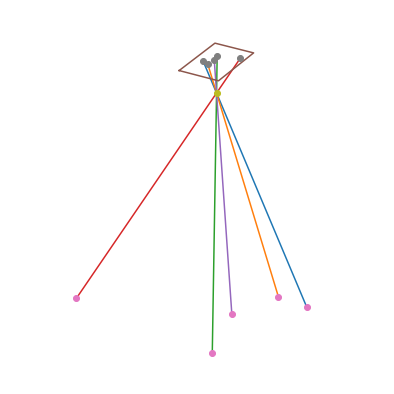

In [7]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(121, projection='3d')
for i in range(n):
    ax.plot([X[i],-x[i]],[Y[i],-y[i]],[Z[i],-f])
ax.plot(implane[:,0],implane[:,1],implane[:,2])
ax.plot(X,Y,Z,'o')
ax.plot(-x,-y,-f,'o')
ax.plot([0.0],[0.0],[0.0],'o')
#ax.view_init(0, 90)
ax.set_zlim3d(30,0)
ax.set_axis_off() 

The pinhole camera model produces images that are upside down. To avoid that it is a common practice to assume a virtual image plane that is in front of the pinhole at distance $f$ as shown in the following figure.

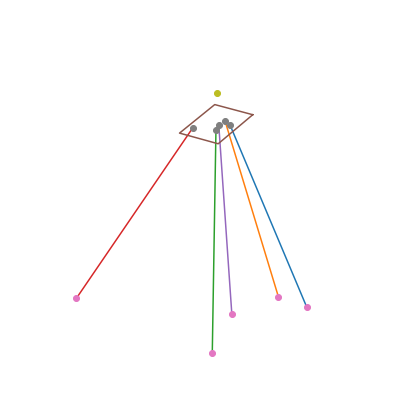

In [8]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(121, projection='3d')
for i in range(n):
    ax.plot([X[i],x[i]],[Y[i],y[i]],[Z[i],f])
ax.plot(-implane[:,0],-implane[:,1],-implane[:,2])
ax.plot(X,Y,Z,'o')
ax.plot(x,y,f,'o')
ax.plot([0.0],[0.0],[0.0],'o')
ax.set_zlim3d(30,0)
ax.set_axis_off() 

## Perspective distortion

To illustrate the effect of perspective distortion, we create a simple polygon model and visualize it from two different viewpoints. 

In [9]:
pts=[
    [0,0,0],
    [2,0,0],
    [0,1,0],
    [2,1,0],
    [0,0,1],
    [2,0,1],
    [0,1,1],
    [2,1,1],
    [0,0.5,1.5],
    [2,0.5,1.5]]

In [10]:
verts=np.array([
    [pts[0],pts[1],pts[3],pts[2],pts[0]],
    [pts[0],pts[2],pts[6],pts[4],pts[0]],
    [pts[0],pts[1],pts[5],pts[4],pts[0]],
    [pts[1],pts[3],pts[7],pts[5],pts[1]],
    [pts[2],pts[3],pts[7],pts[6],pts[2]],
    [pts[4],pts[5],pts[9],pts[8],pts[4]],
    [pts[6],pts[7],pts[9],pts[8],pts[6]],
    [pts[4],pts[6],pts[8],pts[4]],
    [pts[5],pts[7],pts[9],pts[5]]
])

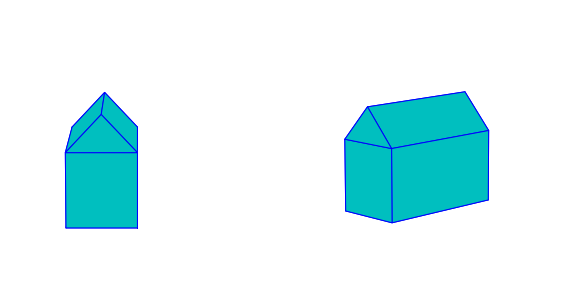

In [11]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection='3d')
ax.add_collection3d(Poly3DCollection(verts,facecolors='c',edgecolors='b'))
ax.set_xlim3d(0,2)
ax.set_ylim3d(0,2)
ax.set_zlim3d(0,2)
ax.set_axis_off() 
ax.view_init(10, 0)
ax = fig.add_subplot(122, projection='3d')
ax.add_collection3d(Poly3DCollection(verts,facecolors='c',edgecolors='b'))
ax.set_xlim3d(0,2)
ax.set_ylim3d(0,2)
ax.set_zlim3d(0,2)
ax.set_axis_off() 
ax.view_init(10, 45)

We observe that under perspective projection, lines project as lines, but angles between lines can change. Also, new details can appear because of self-occlusion.

## Lens distortion

Wide angle lenses have short focal lengths, and they are typically subject to geometric distortion. Next, we simulate lens distortion using a simple model for radial distortion with one coefficient.

In [12]:
x,y = np.meshgrid(np.arange(-1,1.01,0.01),np.arange(-1,1.01,0.01))

In [13]:
r2 = x**2 + y**2

In [14]:
k1 = -0.1

In [15]:
xb = x * (1 + k1 * r2)
yb = y * (1 + k1 * r2)

In [16]:
xp = x * (1 - k1 * r2)
yp = y * (1 - k1 * r2)

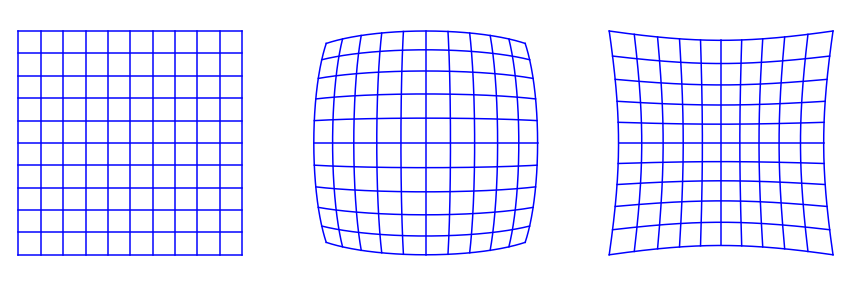

In [17]:
fig = plt.figure(figsize=(15,5))
plt.subplot(131)
for i in range(11):
    plt.plot(x[i*20,:],y[i*20,:],'b')
    plt.plot(x[:,i*20],y[:,i*20],'b')
plt.axis('equal')
plt.axis('off')
plt.subplot(132)
for i in range(11):
    plt.plot(xb[i*20,:],yb[i*20,:],'b')
    plt.plot(xb[:,i*20],yb[:,i*20],'b')
plt.axis('equal')
plt.axis('off')
plt.subplot(133)
for i in range(11):
    plt.plot(xp[i*20,:],yp[i*20,:],'b')
    plt.plot(xp[:,i*20],yp[:,i*20],'b')
plt.axis('equal')
plt.axis('off');

The first image shows a grid without distortion, the second image has barrel distortion, and the third one has pincushion distortion.

## Thin lens model

Pinhole model is usually a sufficient camera model for explaining the projection from 3D points to 2D image points. It assumes that all rays go through a single infinitesimally small hole and project to the image plane behind. In real cameras the rays go through a lens system with the aperture size of $D$. The thin lens model approximates the behavior of the rays in that case.

Next, we define a function that simulates defocus blur using the thin lens model. 

In [18]:
def defocus_blur(img,depth,f,D,fdist):
    """
    img is the input image.
    depth is a depth map giving the depth value for every pixel in the image.
    f is the focal length of the camera.
    D is the aperture size (diameter) of the lens.
    fdist is the focus distance.
    """
    m,n = depth.shape
    zf=1/(1/f-1/fdist)
    zi=1/(1/f-1/depth)
    dz=abs(zf-zi)
    c=D/zi*dz*m/2     # Circle of confusion in pixels
    ci=np.linspace(c.min(),c.max(),20)
    dc=np.digitize(c,ci)
    blurred=np.zeros(img.shape).astype(np.uint8)
    for i in range(20):
        # Sigma of the Gaussian blur kernel is assumed to be the radius of
        # the circle of confusion plus a small constant
        sigma=ci[i]/2+0.01
        gblur=cv2.GaussianBlur(img,(0,0),sigma)
        mask=(dc==i+1).astype(np.uint8)
        blurred+=cv2.bitwise_and(gblur,gblur,mask=mask)
    return blurred

In [19]:
help(defocus_blur)

Help on function defocus_blur in module __main__:

defocus_blur(img, depth, f, D, fdist)
    img is the input image.
    depth is a depth map giving the depth value for every pixel in the image.
    f is the focal length of the camera.
    D is the aperture size (diameter) of the lens.
    fdist is the focus distance.



We demonstrate the defocus blur with a synthetic image for which we also know the depth in every pixel.

In [20]:
img = cv2.cvtColor(cv2.imread('images/toy_scene.png'),cv2.COLOR_BGR2RGB)

In [21]:
depth = np.load('images/toy_scene_depth.npy')

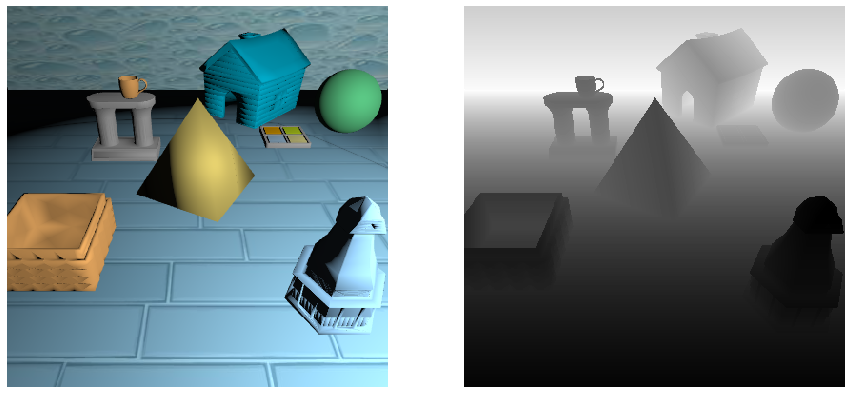

In [22]:
fig = plt.figure(figsize=(15,7))
plt.subplot(121)
plt.imshow(img)
plt.axis('off')
plt.subplot(122)
plt.imshow(depth, cmap='gray')
plt.axis('off');

The focal length of the camera is known to be 1.732.

In [23]:
f=1.732

We use the aperture stop (F-number) value of f/2 to define the aperture size.

In [24]:
D=f/2

We focus the lens to the foreground (closest point in the scene).

In [25]:
fg = defocus_blur(img,depth,f,D,depth.min())

Then we create another image where the lens has been focused to the background (furthest point).

In [26]:
bg = defocus_blur(img,depth,f,D,depth.max())

The resulting images are shown below.

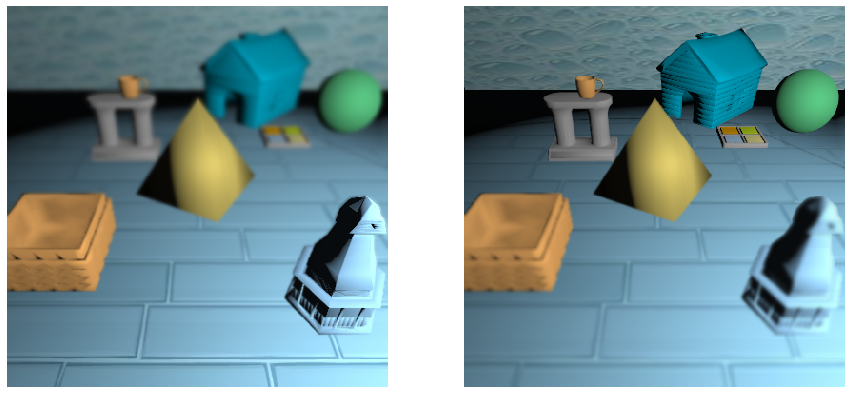

In [27]:
fig = plt.figure(figsize=(15,7))
plt.subplot(121)
plt.imshow(fg)
plt.axis('off')
plt.subplot(122)
plt.imshow(bg)
plt.axis('off');

We notice that the depth of field is quite shallow.

Next, we change the aperture stop to f/8 and repeat the experiment.

In [28]:
D=f/8

In [29]:
fg2 = defocus_blur(img,depth,f,D,depth.min())
bg2 = defocus_blur(img,depth,f,D,depth.max())

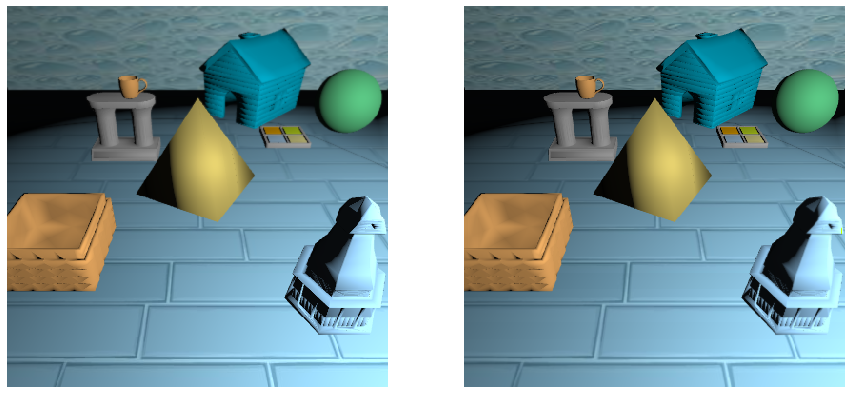

In [30]:
fig = plt.figure(figsize=(15,7))
plt.subplot(121)
plt.imshow(fg2)
plt.axis('off')
plt.subplot(122)
plt.imshow(bg2)
plt.axis('off');

The depth of field has clearly extended, and the scene is almost in focus at every distance.

Decreasing the aperture size increases the depth of field, but it also decreases the amount of light passed to the image plane. For example, when we change the aperture stop from f/2 to f/4, the amount of light decreased by 4. Hence, if we keep the exposure time constant when decreasing the aperture size, the resulting image would look like this:

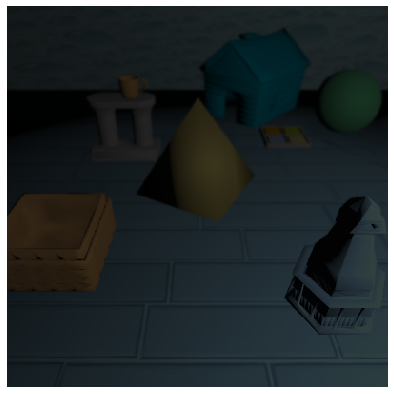

In [31]:
D=f/4
fg3 = defocus_blur(img,depth,f,D,depth.min())

fig = plt.figure(figsize=(7,7))
plt.imshow((fg3/4).astype(np.uint8))
plt.axis('off');

To compensate for the loss in the light we need to use 4 times longer exposure time for having the same brightness (exposure value or EV) as before.

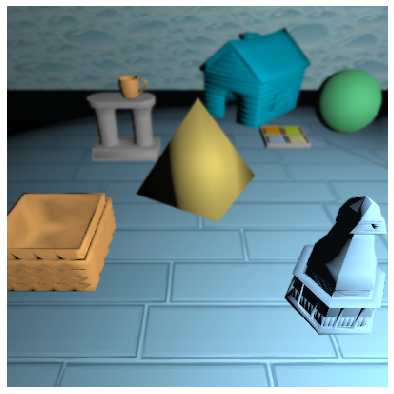

In [32]:
fig = plt.figure(figsize=(7,7))
plt.imshow((fg3))
plt.axis('off');

## Vignetting
Next we simulate the effect of brightness falloff towards the image boundaries using the "cosine fourth" law.

In [33]:
xi, yi = np.meshgrid(range(img.shape[1]),range(img.shape[0]))
xi = xi.astype(np.float32) - img.shape[1]/2
yi = yi.astype(np.float32) - img.shape[0]/2
di = np.sqrt(xi**2 + yi**2)

In [34]:
fp = f*img.shape[0]/2       #This is the focal length in pixels

In [35]:
alpha = np.arctan2(di,fp)

In [36]:
falloff = np.cos(alpha)**4
falloff = np.stack([falloff, falloff, falloff], axis=2)

In [37]:
vig = (img * falloff).astype(np.uint8)

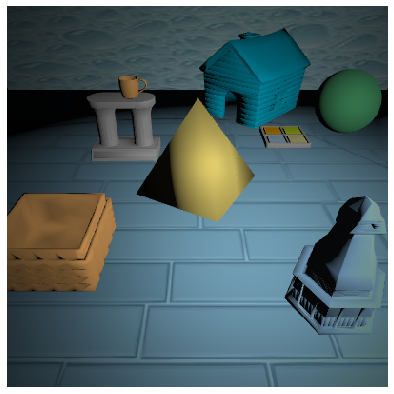

In [38]:
plt.figure(figsize=(7,7))
plt.imshow(vig)
plt.axis('off');

## Image noise
Here we generate two images with realistic shot noise. The first image represents low illumination conditions or short exposure time. In the second image the exposure (= amount of light per unit area) is 10 times higher.

In [39]:
scale = 1.0
image1 = np.zeros((256,256,3), dtype=np.uint8)
for i in range(256):
    image1[:,i,:] = np.clip(np.random.poisson(i*scale,(256,3))/scale, 0, 255).astype(np.uint8)

In [40]:
scale = 10.0
image2 = np.zeros((256,256,3), dtype=np.uint8)
for i in range(256):
    image2[:,i,:] = np.clip(np.random.poisson(i*scale,(256,3))/scale, 0, 255).astype(np.uint8)

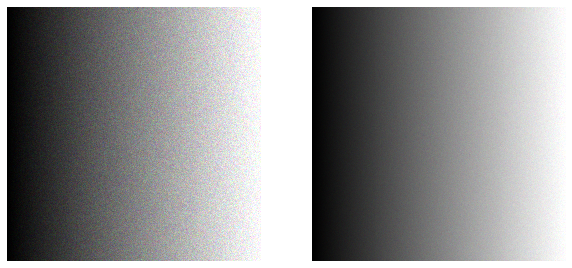

In [41]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(image1)
plt.axis('off')
plt.subplot(122)
plt.imshow(image2)
plt.axis('off');

## Gamma effect
There is a nonlinear relationship between the real intensity and the brightness what we perceive.

In [42]:
brightness, _ = np.meshgrid(np.linspace(0,1,512),range(0,100))

In [43]:
intensity = brightness**2.22

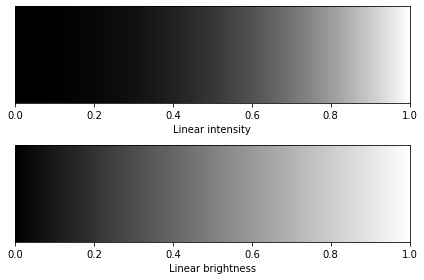

In [44]:
plt.subplot(211)
plt.imshow(intensity,cmap='gray',extent=[0,1,0,1], aspect='auto')
plt.yticks([])
plt.xlabel('Linear intensity')
plt.tight_layout()
plt.subplot(212)
plt.imshow(brightness,cmap='gray',extent=[0,1,0,1], aspect='auto')
plt.yticks([])
plt.xlabel('Linear brightness')
plt.tight_layout();

That is why the images need to be gamma pre-corrected (gamma encoded) in the camera to make them better suited for the human eye. The next example shows how the image looks without gamma pre-correction.

In [45]:
before_gamma = (((img/255.0)**2.22)*255.0).astype(np.uint8)

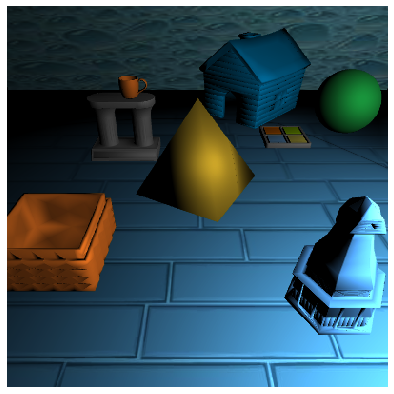

In [46]:
plt.figure(figsize=(7,7))
plt.imshow(before_gamma)
plt.axis('off');

## Demosaicing
Here we simulate image acquisition with the Bayer color filter array (CFA) and conversion to an RGB image.

In [47]:
img = cv2.imread('images/fruits.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

This is the basic Bayer pattern.

In [48]:
bmask = np.zeros((2,2,3))
bmask[1,0,0] = 1
bmask[0,0,1] = 1
bmask[1,1,1] = 1
bmask[0,1,2] = 1

The CFA is created by repeating the pattern to cover all pixels of the image.

In [49]:
bpattern = np.kron(np.ones((int((img.shape[0]/2)), int(img.shape[1]/2), 1)), bmask).astype(np.uint8)

Here is a small part of the CFA.

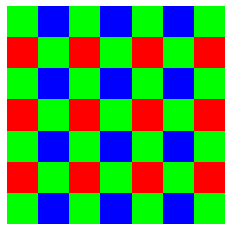

In [50]:
plt.imshow(bpattern[0:7,0:7]*255)
plt.axis('off');

Next we filter the image to simulate the output of the image sensor.

In [51]:
bayer = img * bpattern
bayer = np.sum(bayer, axis = 2)

Notice that the result has only one channel. Then, we use the color transformation from OpenCV to perform demosaicing (converting the filtered image to an RGB image with three channels).

In [52]:
debayer = cv2.cvtColor(bayer.astype(np.uint8),cv2.COLOR_BAYER_GR2RGB)

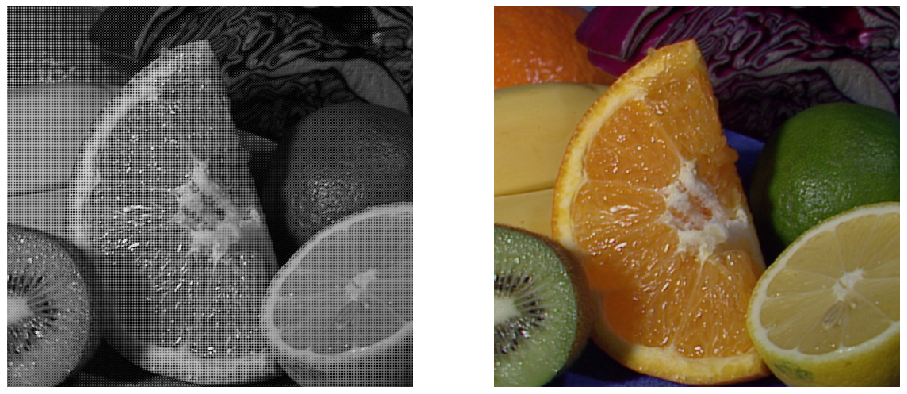

In [53]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(bayer,cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(debayer)
plt.axis('off');

## White balance
Image colors depend on the properties of the surfaces and light. To demonstrate the need for white balancing we simulate bluish lighting conditions by multiplying the R channel with 0.7 and the B channel with 1.5.

In [54]:
wb = img.copy()
wb[:,:,0] = np.clip(wb[:,:,0]*0.7, 0, 255).astype(np.uint8)
wb[:,:,2] = np.clip(wb[:,:,2]*1.5, 0, 255).astype(np.uint8)

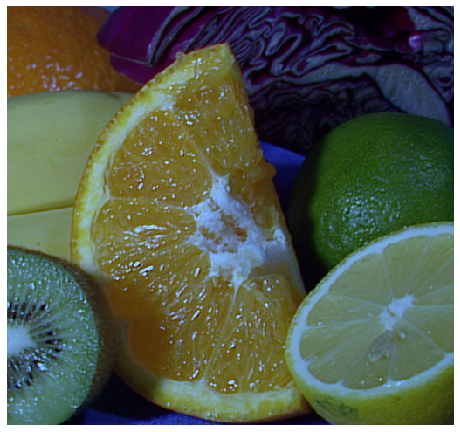

In [55]:
plt.figure(figsize=(8,8))
plt.imshow(wb)
plt.axis('off');